In [9]:
import pandas as pd

from util.sql_switch import get_query_native

count_query = "select count(ds.title), ds.title, ds.created_at \
from delab_moderationrating mr \
    join delab_moderationcandidate2 d on mr.mod_candidate_id = d.id \
    join delab_tweet dt on dt.id = d.tweet_id \
    join delab_simplerequest ds on dt.simple_request_id = ds.id \
where mr.u_moderating_part is not null \
  and mr.u_moderating_part <> '' \
group by \
    ds.title, ds.created_at \
order by count(ds.title) desc"

df_term_counts = get_query_native(count_query)
# print(df_term_counts.head(8))


# squashing similar titles
import functools as ft

list_of_similar_terms = [["Thema"], ["calm", "down"], ["constructive", "criticism"], ["explain"],
                         ["topic"], ["whataboutism"], ["valid", "point"], ["Perspektive"], ["agree"],
                         ["summary"], ["sachlich"]]

# list_of_similar_terms = []

def title_group_mapper(text):
    group_title = text
    for term_group in list_of_similar_terms:
        for term in term_group:
            if term in text and group_title == text:
                group_title = ft.reduce(lambda x, y: x + "_" + y, term_group)
    return group_title


grouped_titles = df_term_counts["title"].map(title_group_mapper)
df_term_counts["grouped_titles"] = grouped_titles
df_term_counts.drop(["title", "created_at"], axis=1, inplace=True)
df_term_counts = df_term_counts.groupby("grouped_titles").sum()
df_term_counts.sort_values(by=["count"], axis=0, inplace=True, ascending=False)
df_term_counts.head(10)

using postgres


/home/dehne/PycharmProjects/delab/venv/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,count
grouped_titles,
sachlich,131
Thema,88
topic,72
"""hear your view""",50
explain,45
valid_point,43
"""can you elaborate""",42
"""näher erläutern""",39
constructive_criticism,34


# Summary of biggest inter-coder conflicts

- load moderation rating from database or use previous
- show a list of top 10 conflicting ratings

In [10]:
import numpy as np

intercoder_query = "select dt.text, ds.created_at, ds.title, mr.u_moderating_part, mr.u_mod_rating as rating1, mr2.u_mod_rating as rating2, mr.mod_coder_id as coder_id_1, mr2.mod_coder_id as coder_id_2 \
from delab_moderationrating mr \
    join delab_moderationcandidate2 d on mr.mod_candidate_id = d.id \
    join delab_moderationrating mr2 on mr2.mod_candidate_id = d.id \
    join delab_tweet dt on dt.id = d.tweet_id \
    join delab_simplerequest ds on dt.simple_request_id = ds.id \
where mr.u_moderating_part is not null \
  and mr.u_moderating_part <> '' \
  and ds.created_at > '2022-09-01 00:00:00' \
  and mr.mod_coder_id <> mr2.mod_coder_id \
  and mr.u_mod_rating <> mr2.u_mod_rating;"

df_ic = get_query_native(intercoder_query)
df_ic.drop_duplicates("text", inplace=True)
grouped_titles = df_ic["title"].map(title_group_mapper)
df_ic["grouped_titles"] = grouped_titles
df_ic.drop("title", axis=1, inplace=True)


# print(df_ic.head(3))

def calculate_coding_distance(df):
    bigger = df.max(axis=1)
    smaller = df.min(axis=1)
    result = (bigger - smaller).abs()
    return result


df_ic["intercoder_distance"] = calculate_coding_distance(df_ic[["rating1", "rating2"]])
df_ic.sort_values(by="intercoder_distance", inplace=True, ascending=False)

df_ic.head(10)

using postgres


/home/dehne/PycharmProjects/delab/venv/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,text,created_at,u_moderating_part,rating1,rating2,coder_id_1,coder_id_2,grouped_titles,intercoder_distance
496,"@gregswimelar @ehanford @CLPeak This is new to us. Can you please help us understand how the SOR movement is political? We would like to understand your perspective. It’s very, very different from the one we’ve encountered as a group. We are a very bipartisan group. VERY",2022-11-24 16:02:47.377066+00:00,We would like to understand your perspective.,2,-2,11,1,"""would like to understand""",4
172,"@Beingmen2 @KirenRijiju @PMOIndia R/Mam, Don't you think that Firstly we need to Focus on Topic:""How we will reduce Huge Burden of Matrimonial cases over Judiciary.""\nDon't we need to Stop Marriages atleast for next 5 years.\nWhich will helpout to control our Population &amp; reduce the burden of matrimonial cases.",2022-11-17 10:42:24.589267+00:00,"Don't you think that Firstly we need to Focus on Topic:""How we will reduce Huge Burden of Matrimonial cases over Judiciary.""",2,-2,11,1,topic,4
175,"@taysrep89 @circusaintlove As a fan since 2009 I agree with you on this, some swifties have lost their minds and have become so aggressive, entitled and toxic, it´s sad to watch💔",2022-11-17 10:00:01.918688+00:00,"As a fan since 2009 I agree with you on this, some swifties have lost their minds and have become so aggressive, entitled and toxic, it´s sad to watch💔",2,-2,11,1,agree,4
176,"@EricCryptoman Would love to hear your view on #CB, the project looks solid and have been catching many eyes lately, low mc, low tax of 7% and their Dapp is releasing soon\n\n#CB $CB #BTC #ETH @thecloutbase https://t.co/Mz33ObvLso",2022-11-17 10:50:52.533139+00:00,"Would love to hear your view on #CB, the project looks solid and have been catching many eyes lately, low mc, low tax of 7% and their Dapp is releasing soon",2,-2,11,1,"""hear your view""",4
177,"@austinahilton @BananaTFA @thecryptoshopp Would love to hear your view on #CB, the project looks solid and have been catching many eyes lately, low mc, low tax of 7% and their Dapp is releasing soon\n\n#CB $CB #BTC #ETH @thecloutbase https://t.co/ovoMgh174y",2022-11-17 10:50:52.533139+00:00,"Would love to hear your view on #CB, the project looks solid and have been catching many eyes lately, low mc, low tax of 7% and their Dapp is releasing soon #CB $CB #BTC #ETH",2,-2,11,1,"""hear your view""",4
178,@RazzberryYams @LittleKeegs0 @Staroxvia @vanillaopinions what do you mean. The veil of ignorance isn't made up of people that will ever exist,2022-11-17 09:54:28.305338+00:00,what do you mean,2,-2,11,1,"what ""you mean""",4
179,Hi @__Enia. Thank you again for taking the time to provide your feedback! We really appreciate that! Take note that the tariff adjustment is necessitated by the increased operational costs as we want to continue providing exceptional services. ^TC,2022-11-17 10:33:50.514645+00:00,Thank you again for taking the time to provide your feedback! We really appreciate that!,2,-2,11,1,appreciate feedback,4
180,"@JakeGagain Would love to hear your view on #CB, the project looks solid and have been catching many eyes lately, low mc, low tax of 7% and their Dapp is releasing soon\n\n#CB $CB #BTC #ETH @thecloutbase https://t.co/TP9pUNpDg5",2022-11-17 10:50:52.533139+00:00,"Would love to hear your view on #CB, the project looks solid and have been catching many eyes lately, low mc, low tax of 7% and their Dapp is releasing soon #CB $CB #BTC #ETH",2,-2,11,1,"""hear your view""",4
181,"@RNR_0 Thanks man, appreciate it! I’m fine, just shocked and disappointed it had to end like this. We had something great.. Your feedback was always very helpful 🤝",2022-11-17 10:33:50.514645+00:00,"Thanks man, appreciate it!; Your feedback was always very helpful 🤝",2,-2,11,1,appreciate feedback,4
182,@zackberjawi It should be slightly raised due to the pocket placement but definitely depends a bit on how full the bag is. Certainly open to feedback if there are issues,2022-11-17 10:24:53.594081+00:00,Certa

# Summary of inter-coder-reliability over time and per phrases
- load the dataset from the db
- set 2 to 1, and -2 to -1 for simplicity
- compute Krippendorf-Alpha for the ratings
- plot Krippendorf-Alpha over time globally
- plot Krippendorf-Alpha over time per title

In [16]:
import simpledorff

inter_coder_reliability_query = "select ds.created_at, ds.title, mr.u_mod_rating, mr.mod_coder_id \
from delab_moderationrating mr \
    join delab_moderationcandidate2 d on mr.mod_candidate_id = d.id \
    join delab_tweet dt on dt.id = d.tweet_id \
    join delab_simplerequest ds on dt.simple_request_id = ds.id \
where mr.u_moderating_part is not null \
  and mr.u_moderating_part <> '' \
  and mr.u_mod_rating <> 0"

df_rel = get_query_native(inter_coder_reliability_query)
grouped_titles = df_rel["title"].map(title_group_mapper)
df_rel["grouped_titles"] = grouped_titles
df_rel.drop("title", axis=1, inplace=True)

value_mapping = {2: 1, -2: -1}
coder_mapping = {1: 1}
for i in range(2, 100):
    coder_mapping[i] = 2
df_rel.replace({"mod_coder_id": value_mapping}, inplace=True)
df_rel.replace({"mr.mod_coder_id": coder_mapping}, inplace=True)
# create new time_stamp_column that takes a time_stamp every 10 units per topic
df_rel["created_at"] = df_rel["created_at"].map(lambda x: pd.to_datetime(x))
df_rel.sort_values(by="created_at", inplace=True)
df_rel.set_index("created_at", inplace=True)


def compute_incremental_krippendorf_column(df):
    df = df.copy(deep=True)
    date2krippendorf = {}

    # debugging code
    if "valid_point" in list(df.grouped_titles):
        print("testing incremental krippendorf")
    if "Sichtweise" in list(df.grouped_titles):
        print("testing krippendorf 0")
    if "sachlich" in list(df.grouped_titles):
        print("testing krippendorf sachlich")

    week_labels_list = []
    for week_index, weekly_labels in df.groupby(pd.Grouper(freq="3D")):
        try:
            week_labels_list.append(weekly_labels)
            week_labels_aggro = pd.concat(week_labels_list)
            s_dorf = simpledorff.calculate_krippendorffs_alpha_for_df(week_labels_aggro, experiment_col='created_at',
                                                                      annotator_col='mod_coder_id',
                                                                      class_col='u_mod_rating')
        except ZeroDivisionError:
            s_dorf = np.NaN

        for date in weekly_labels.index:
            date2krippendorf[date] = s_dorf

    pd.options.mode.chained_assignment = None
    df["krippendorf"] = df.index.map(date2krippendorf)
    return df


# compute the krippendorf for each title_group
krippendorfed_frames = []

for title in set(df_rel.grouped_titles):
    single_title_dataset = df_rel[df_rel["grouped_titles"] == title]
    df_rel_single_with_krippendorf = compute_incremental_krippendorf_column(single_title_dataset)
    krippendorfed_frames.append(df_rel_single_with_krippendorf)

df_rel_with_krippendorf = pd.concat(krippendorfed_frames)
# printing out the codings from the last day and their incremental krippendorf (aggregated over all weeks)
df_rel_with_krippendorf.last("1D")


using postgres


/home/dehne/PycharmProjects/delab/venv/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


testing incremental krippendorf
testing krippendorf 0
testing krippendorf sachlich


,u_mod_rating,mod_coder_id,grouped_titles,krippendorf
created_at,,,,
2022-11-17 10:24:53.594081+00:00,2,11,"""open to feedback""",NaN
2022-11-17 10:24:53.594081+00:00,2,11,"""open to feedback""",NaN
2022-11-17 10:24:53.594081+00:00,2,11,"""open to feedback""",NaN
2022-11-17 10:24:53.594081+00:00,2,11,"""open to feedback""",NaN
2022-11-17 10:24:53.594081+00:00,2,11,"""open to feedback""",NaN
...,...,...,...,...
2022-11-17 09:29:14.609638+00:00,1,1,"""can you elaborate""",0.0
2022-11-17 09:29:14.609638+00:00,2,11,"""can you elaborate""",0.0
2022-11-17 09:29:14.609638+00:00,1,1,"""can you elaborate""",0.0


### Summary of best working Terms:
- sorted by the highest krippendorf at the current time aggregating all data
- grouped by the phrases

In [12]:
df_rel_highest_icr = df_rel_with_krippendorf.groupby("grouped_titles").last()
df_rel_highest_icr = df_rel_highest_icr.drop(["u_mod_rating", "mod_coder_id"], axis=1)
df_rel_highest_icr = df_rel_highest_icr[df_rel_highest_icr["krippendorf"] != 0]
df_rel_highest_icr.sort_values(by="krippendorf", inplace=True, ascending=False)


# computed the krippendorf column
# listing the highest icr by grouped_title
df_rel_highest_icr.head(10)

,krippendorf
grouped_titles,
Thema,0.230769
valid_point,0.193548
explain,-0.037037
constructive_criticism,-0.076923
topic,-0.222222
agree,-0.500000
"""Meinung hören""",NaN
"""arguments presented""",NaN
"""can you respond""",NaN


In [13]:
#calculate overall average of krippendorf

inter_coder_reliability_query = "select ds.created_at, ds.title, mr.u_mod_rating, mr.mod_coder_id \
from delab_moderationrating mr \
    join delab_moderationcandidate2 d on mr.mod_candidate_id = d.id \
    join delab_tweet dt on dt.id = d.tweet_id \
    join delab_simplerequest ds on dt.simple_request_id = ds.id \
where mr.u_moderating_part is not null \
  and mr.u_moderating_part <> ''"

df_rel_2 = get_query_native(inter_coder_reliability_query)

s_dorf = simpledorff.calculate_krippendorffs_alpha_for_df(df_rel_2, experiment_col='created_at',
                                                          annotator_col='mod_coder_id',
                                                          class_col='u_mod_rating')
s_dorf

using postgres


/home/dehne/PycharmProjects/delab/venv/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


-0.07384263925283885

# Computing Time Sliced Development of Krippendorf

- write procedure to slice the dataframe in time spans of a week
- calculate the krippendorf per title group and week (if possible)
- plot the changes in krippendorf over time

<AxesSubplot:xlabel='created_at'>

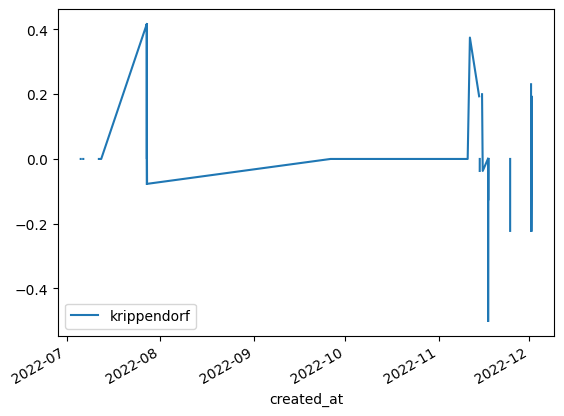

In [14]:
# krippendorf alpha for all terms
df_rel_with_krippendorf.plot.line(y="krippendorf")




Alle 0 für constructive_criticism!>
Alle 0 für topic!>


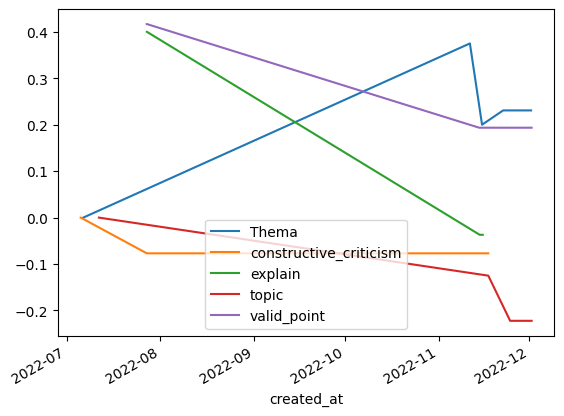

In [15]:
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt

top_5_titles = df_rel_highest_icr.head(5)
df_rel_top_5 = df_rel_with_krippendorf[df_rel_with_krippendorf["grouped_titles"].isin(top_5_titles.index.to_list())]
#df_rel_top_5.reset_index(inplace=True)

fig, ax = plt.subplots()

for key, grp in df_rel_top_5.groupby(['grouped_titles']):
    if grp.empty:
        print('DataFrame is empty for title {}!'.format(key))
    if grp[grp["krippendorf"] > 0].empty:
        print('Alle 0 für {}!>'.format(key))
    ax = grp.plot(ax=ax, kind='line', y='krippendorf', label=key)
#ax.set_xlim([datetime.date(2022, 9, 15), datetime.date(2023, 1, 1)])
plt.legend(loc='best')
plt.show()
